In [ ]:
import os
import glob
import xarray as xr
dataDir = "/home/ant/Downloads/podaac"

In [ ]:
import dask.dataframe as dd
import dask.multiprocessing
from dask.distributed import Client
from dask.diagnostics import ProgressBar
client = Client(n_workers = 10, threads_per_worker = 4)  # set up local cluster on your laptop
client

/home/ant/miniconda3/envs/thesis/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37571 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37571/status,
Dashboard: http://127.0.0.1:37571/status,Workers: 10
Total threads: 40,Total memory: 15.01 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35417,Workers: 10
Dashboard: http://127.0.0.1:37571/status,Total threads: 40
Started: Just now,Total memory: 15.01 GiB
Comm: tcp://127.0.0.1:34841,Total threads: 4
Dashboard: http://127.0.0.1:34317/status,Memory: 1.50 GiB
Nanny: tcp://127.0.0.1:32807,


In [ ]:
import os
# Necessary to import Basemap
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


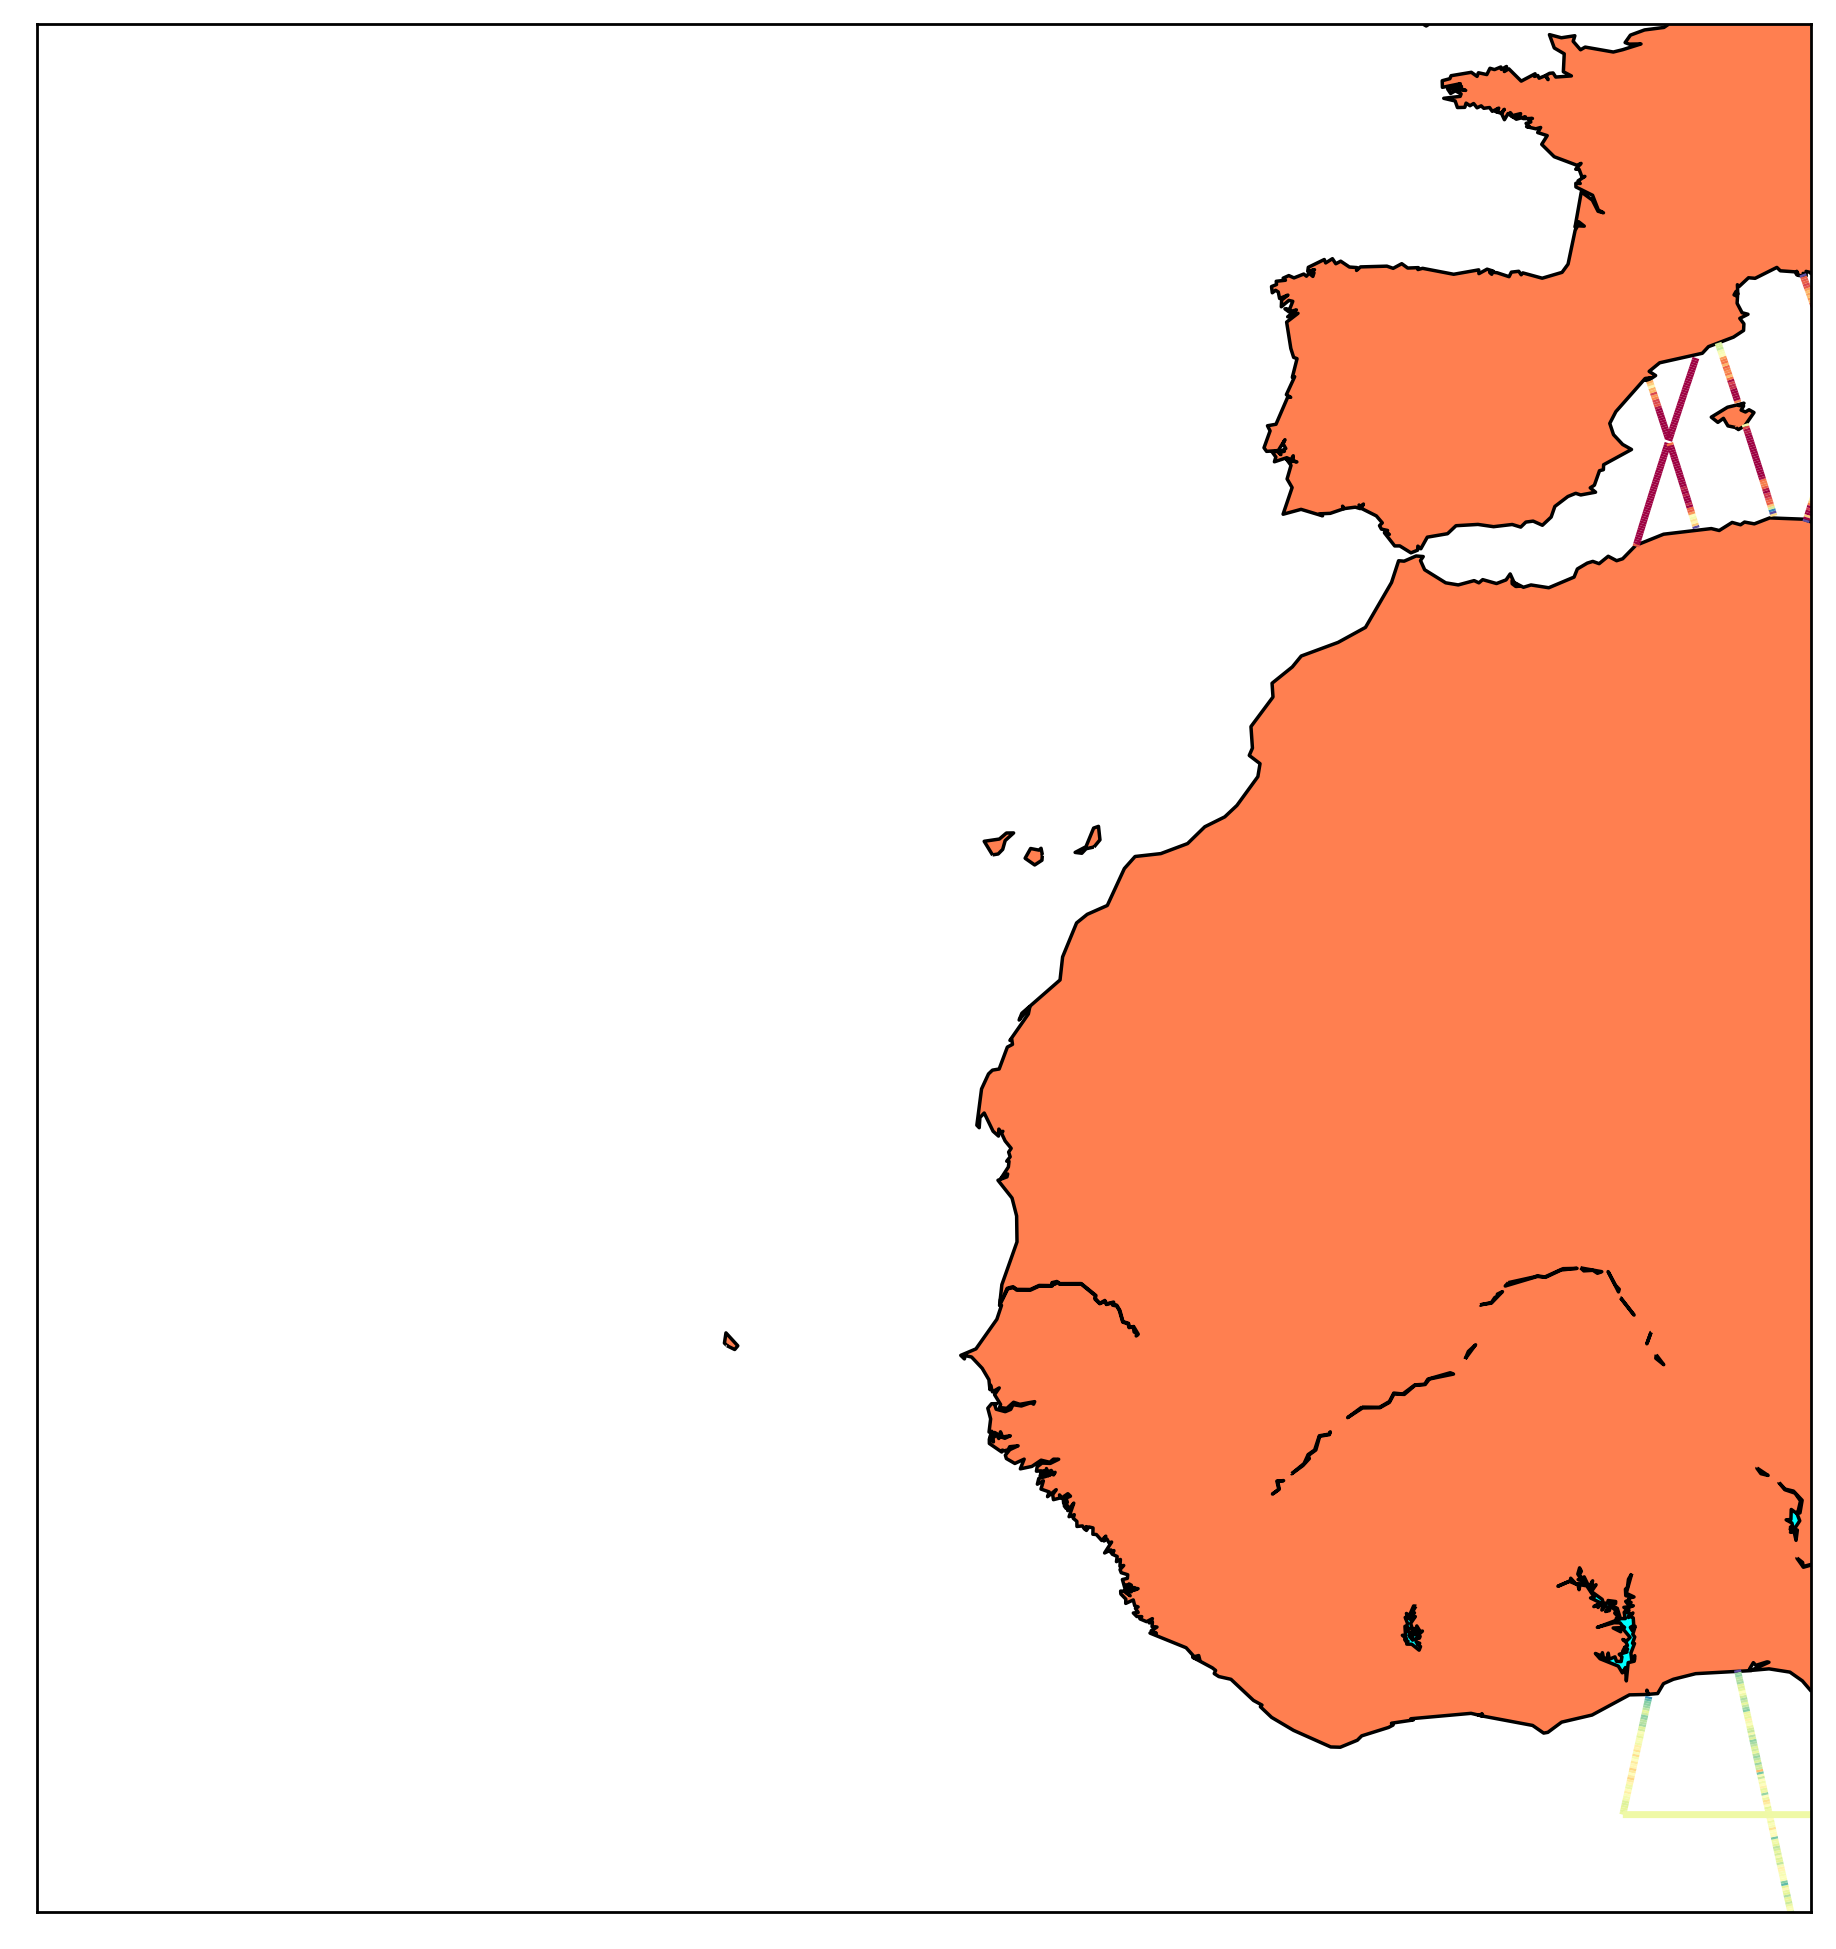

In [ ]:
norm=plt.Normalize(-0.1,0.1)
m = Basemap(llcrnrlon=-42,llcrnrlat=0,urcrnrlon=5,urcrnrlat=50, resolution='l')
fig = plt.figure(figsize=(20,10), dpi=250)
m.drawcoastlines()
#m.drawcountries()
m.fillcontinents(color='coral',lake_color='aqua')

for f in glob.glob(dataDir+'/JFM/*.nc'):
    #print(f)
    dataset = xr.open_dataset(f)
    lon = dataset.lon.values
    lat = dataset.lat.values
    ssh = dataset.ssha_dyn.values

    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    #segments = np.concatenate([points[:-2], points[1:-1], points[2:]], axis=1) ## smoother, since we take 3 points instead of 2 per segment
    lc = LineCollection(segments, cmap=plt.get_cmap('Spectral'), norm=norm)
    lc.set_array(ssh)
    lc.set_linewidth(2)
    plt.gca().add_collection(lc)

axcb = fig.colorbar(lc)
axcb.set_label('ssha (m)')

plt.show()

Files:   0%|          | 0/1217 [00:00<?, ?it/s]

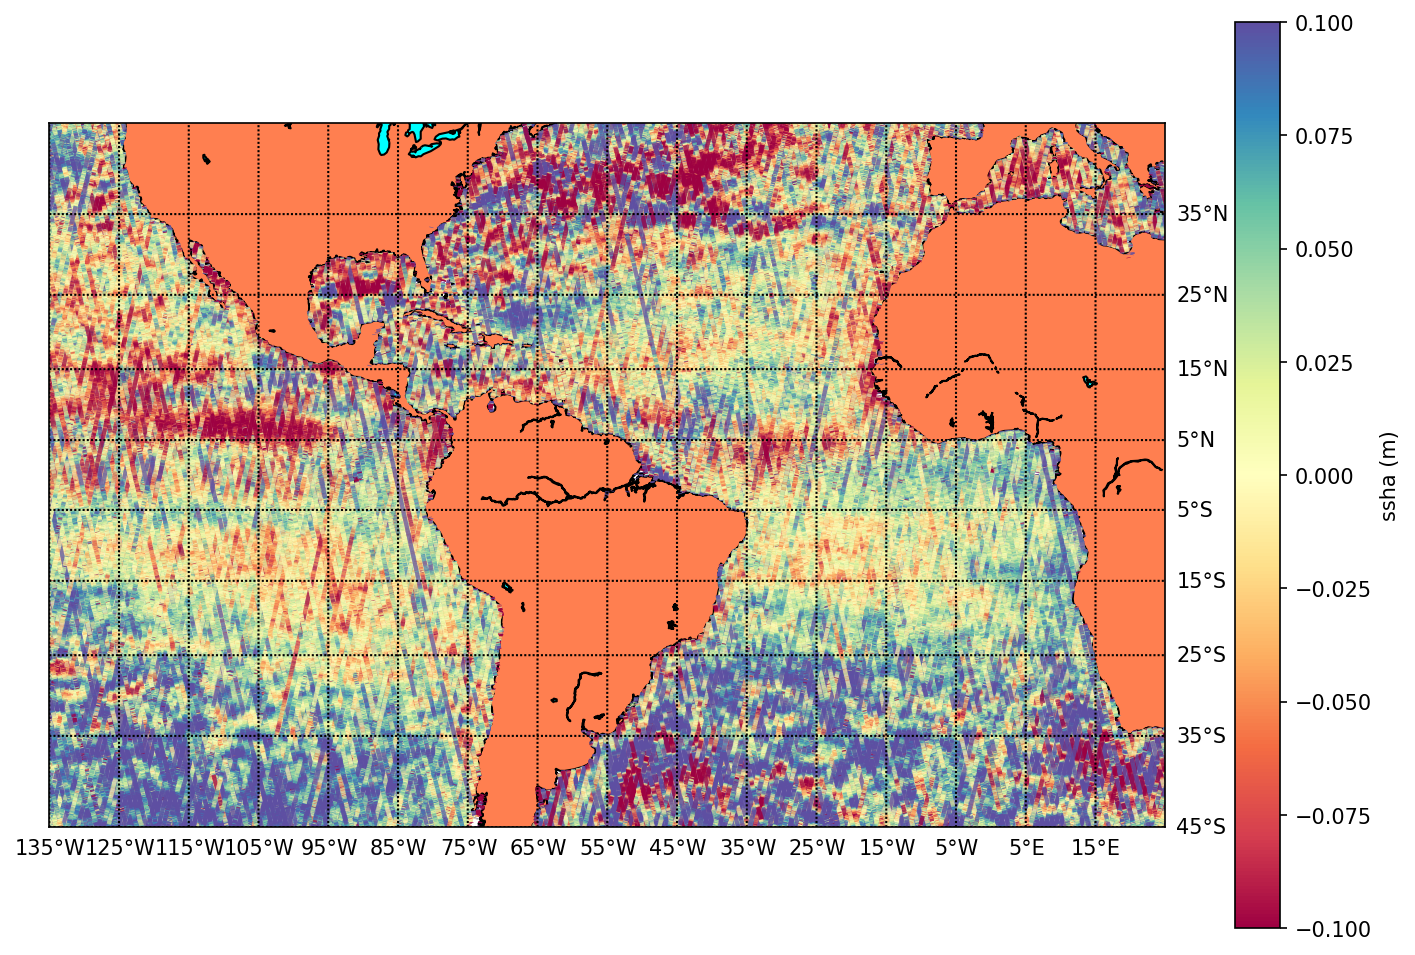

CPU times: user 9.32 s, sys: 499 ms, total: 9.82 s
Wall time: 9.74 s


In [ ]:
import matplotlib.cm as cm
from tqdm.notebook import tqdm, trange
from mpl_toolkits.basemap import Basemap

cmap = plt.get_cmap('Spectral')
norm=plt.Normalize(-0.1,0.1)
minlon,maxlon,minlat,maxlat = (-135,25,-45,45)

fig = plt.figure(figsize=(12,8), dpi=150)
ax = fig.gca()
m = Basemap(projection='merc', llcrnrlat=minlat, urcrnrlat=maxlat, llcrnrlon=minlon, urcrnrlon=maxlon, resolution='l', ax=ax)
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
parallels = np.arange(minlat,maxlat,10.) # Latitudes
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(minlon,maxlon,10.) # Longitudes
m.drawmeridians(meridians,labels=[True,False,False,True])
#m.drawmapboundary(fill_color='w')

#for f in tqdm([f"{dataDir}/JFM/SRL_OPRSSHA_2PTS011_0859_20140329_053853_20140329_072754.EUM.nc"]):
#for f in tqdm(glob.glob(dataDir+'/JFM/*_0909_*.nc'), desc="Files"):
#for f in tqdm(glob.glob(dataDir+'/JFM/*_20140330_*.nc'), desc="Files"):
for f in tqdm(glob.glob(dataDir+'/JFM/*.nc'), desc="Files"):
    #print(f)
    dataset = xr.open_dataset(f)
    lon = np.array([l if l<=180 else l-360 for l in dataset.lon.values])
    lat = dataset.lat.values
    ssh = dataset.ssha_dyn.values
    
    # ** Work in map (figure) coordinates
    xpt,ypt = m(lon,lat)
    points = np.array([xpt, ypt]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1) # 2-point segment
    #segments = np.concatenate([points[:-2], points[1:-1], points[2:]], axis=1) # 3-point segment
    
    # ** Discard segments that go side to side of the map (almost 40000 km long)
    nt,_,_ = segments.shape
    idx = [i for i in range(nt) if np.abs(np.diff(segments[i,:,0]))<39000000]
    segments_filtered,ssh_filtered = segments[idx],ssh[idx]
    
    lc = LineCollection(segments_filtered, cmap=cmap, norm=norm)
    lc.set_array(ssh_filtered)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)

axcb = fig.colorbar(line, ax=ax)
axcb.set_label('ssha (m)')

%time plt.show()